# Transferencia de Aprendizaje para la Clasificación de Flores con Resnet-18

In [7]:
# Importacion de librerias
import os
import time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt  
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

## Descargando dataset

El dataset que usaremos es uno de flores el cual contiene 104 clases.

In [8]:
BATCH_SIZE=32
IMAGE_SIZE = [224, 224]  
AUTO = tf.data.AUTOTUNE

def decode_image(image_data):
    """Convierte bytes a imagen y aplica preprocesamiento de ResNet"""
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image

def read_labeled_tfrecord(example):
    """Parsea un tfrecord con imagen + etiqueta"""
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),  # la imagen como bytes
        "class": tf.io.FixedLenFeature([], tf.int64),   # la etiqueta
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def load_dataset_from_folder(folder):
    filenames = tf.io.gfile.glob(os.path.join(folder, "*.tfrec"))

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)  
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)   
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [9]:
# Rutas
dataset_dir = "DATASETS/flower-classification-with-tpus/tfrecords-jpeg-224x224"
train_folder = f"{dataset_dir}/train"
val_folder   = f"{dataset_dir}/val"
test_folder  = f"{dataset_dir}/test"

# Cargar datasets
train_ds = load_dataset_from_folder(train_folder)
val_ds   = load_dataset_from_folder(val_folder)
test_ds  = load_dataset_from_folder(test_folder)

In [10]:
# Aumentamos los datos de entrenamiento
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)


## Modelo

Usaremos la resnet18 como extractor de características.

In [11]:

NUM_CLASSES = 104  

# Cargar ResNet-50 preentrenada en ImageNet
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,      # quitamos la capa de clasificación original
    weights='imagenet',     # pesos preentrenados
    input_shape=(224, 224, 3)
)

# Congelar la base si quieres transfer learning
base_model.trainable = False

# Crear modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilar modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 104)              

In [12]:
import time

start_time = time.time()

EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1               
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")


Epoch 1/10
399/399 [==============================] - 163s 401ms/step - loss: 1.9650 - accuracy: 0.5272 - val_loss: 0.9937 - val_accuracy: 0.7352
Epoch 2/10
399/399 [==============================] - 163s 408ms/step - loss: 1.1455 - accuracy: 0.6936 - val_loss: 0.7829 - val_accuracy: 0.7912
Epoch 3/10
399/399 [==============================] - 164s 411ms/step - loss: 1.0025 - accuracy: 0.7303 - val_loss: 0.7238 - val_accuracy: 0.8098
Epoch 4/10
399/399 [==============================] - 165s 414ms/step - loss: 0.8922 - accuracy: 0.7535 - val_loss: 0.6750 - val_accuracy: 0.8238
Epoch 5/10
399/399 [==============================] - 171s 428ms/step - loss: 0.8517 - accuracy: 0.7623 - val_loss: 0.6343 - val_accuracy: 0.8359
Epoch 6/10
399/399 [==============================] - 163s 409ms/step - loss: 0.8113 - accuracy: 0.7783 - val_loss: 0.6573 - val_accuracy: 0.8246
Epoch 7/10
399/399 [==============================] - 162s 406ms/step - loss: 0.8037 - accuracy: 0.7753 - val_loss: 0.6364 -

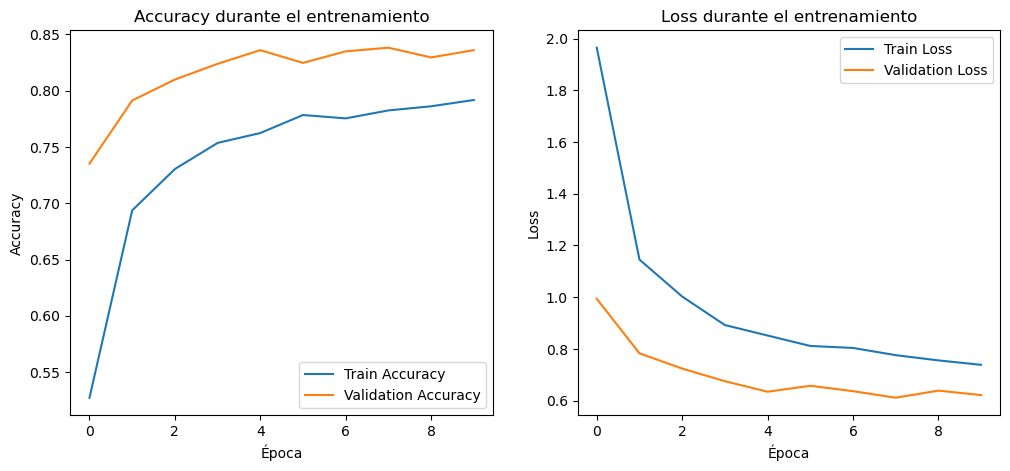

In [13]:
# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [14]:
# Guardamos el modelo
model.save("model.h5")

/home/lcc_rn_08/.conda/envs/medium/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Probamos en nuestro conjunto de test y evaluamos diferentes metricas

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Valores verdaderos.
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Valores predichos por el modelo.
probs = model.predict(val_ds)
y_pred = np.argmax(probs, axis = 1)

116/116 [==============================] - 37s 314ms/step


In [16]:
# Metricas
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy (Global): {acc:.4f}")
print(f"Precision (Weighted): {prec:.4f}")
print(f"Recall (Weighted):    {rec:.4f}")
print(f"F1-Score (Weighted):  {f1:.4f}")

Accuracy (Global): 0.8359
Precision (Weighted): 0.8499
Recall (Weighted):    0.8359
F1-Score (Weighted):  0.8352


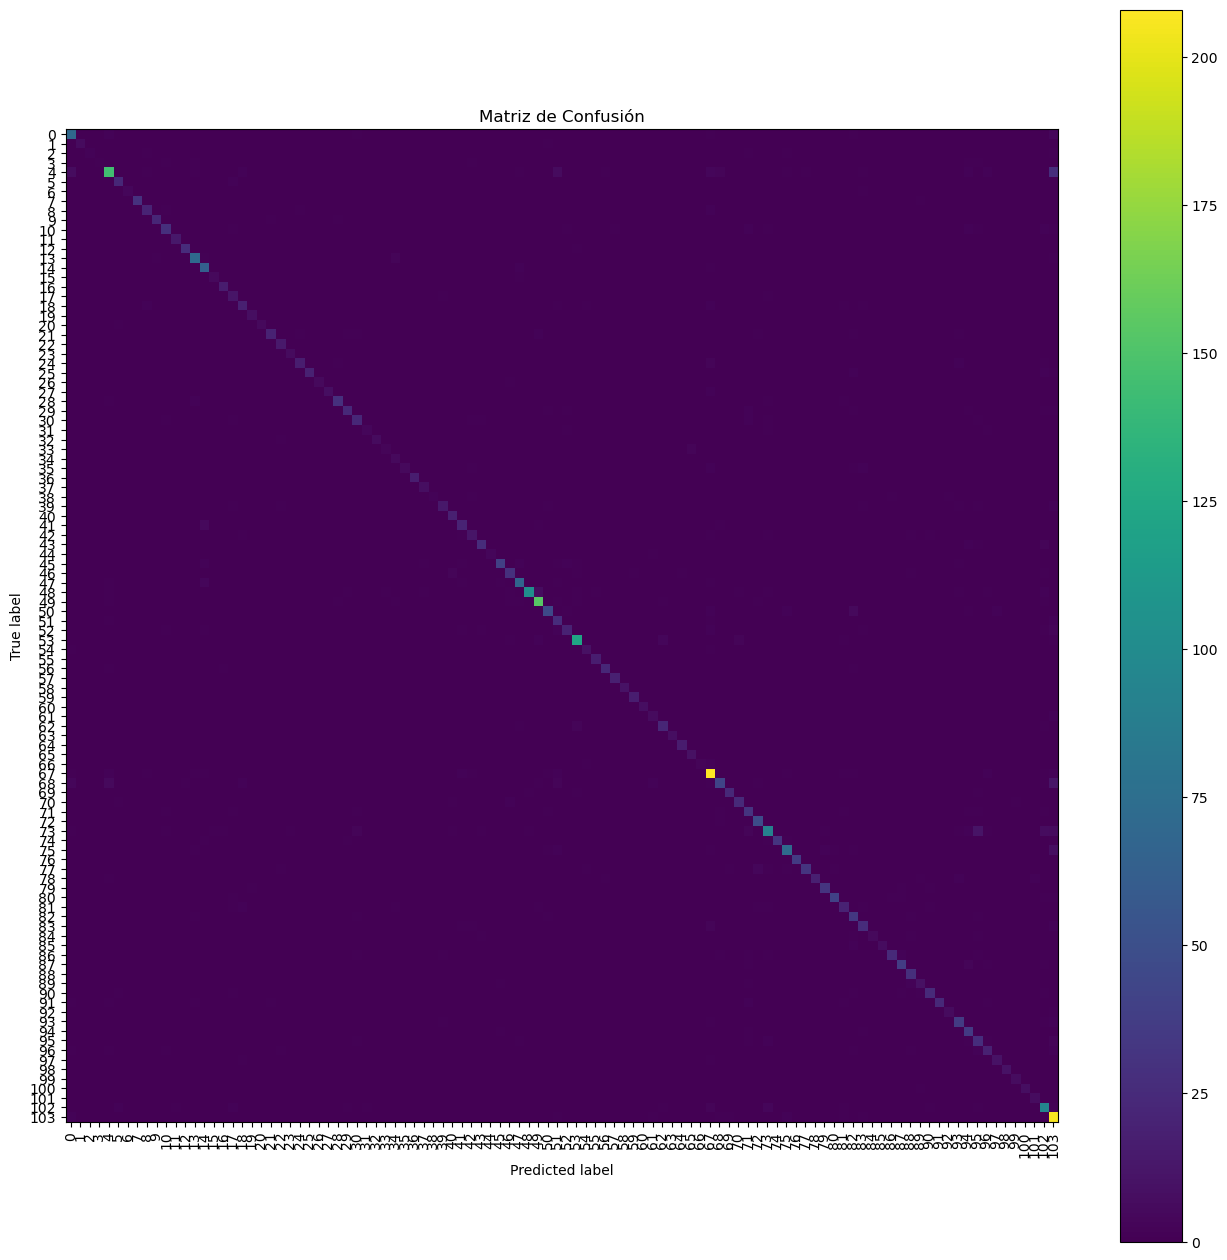

In [17]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(16, 16))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(
    include_values=False,     
    cmap='viridis',           
    ax=ax,                    
    xticks_rotation='vertical'
)

plt.title('Matriz de Confusión')
plt.show()

Y por último vemos el resultado en cada clase

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        79
           1       1.00      0.86      0.92         7
           2       1.00      0.33      0.50         6
           3       1.00      0.17      0.29         6
           4       0.89      0.71      0.79       205
           5       0.82      0.92      0.87        25
           6       1.00      0.80      0.89         5
           7       1.00      0.97      0.98        31
           8       0.81      0.84      0.82        25
           9       0.96      0.92      0.94        24
          10       0.80      0.70      0.75        40
          11       0.93      1.00      0.96        13
          12       0.96      0.96      0.96        27
          13       0.90      0.92      0.91        77
          14       0.81      0.95      0.88        66
          15       0.83      0.83      0.83         6
          16       0.89      1.00      0.94        16
          17       0.52    